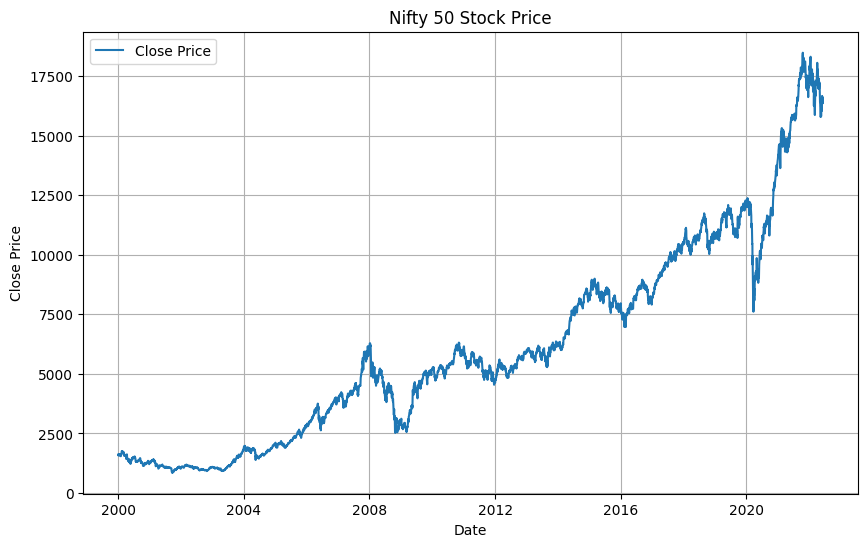

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the stock price data from the CSV file
file_path = r'C:\Desktop\Finsearch_23_G12\Stock_data\Nifty_50_2000-2023\Nifty_50_with_indicators_.csv'
data = pd.read_csv(file_path)

# Convert the 'Date' column to a datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date
data = data.sort_values(by='Date')

# Set the index to the datetime values
data = data.set_index(pd.DatetimeIndex(data['Date'].values))

# Keep only the 'Date' and 'close' columns
data = data[['Date', 'close']]

# Drop rows with missing values
data = data.dropna()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Nifty 50 Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
%pip install pandas_ta

In [2]:
import pandas_ta as ta

def calculate_technical_indicators(df):
    # Calculate technical indicators using the historical price data
    data['RSI'] = ta.rsi(data.close, length=15)
    data['EMAF'] = ta.ema(data.close, length=20)
    data['EMAM'] = ta.ema(data.close, length=100)
    data['EMAS'] = ta.ema(data.close, length=150)
    # Add more technical indicators as needed

    return df

def create_state_space(data, window_size=10):
    """
    Create the state space for stock price prediction.

    Parameters:
        data (pd.DataFrame): Historical stock price data with 'Date' and 'Close' columns.
        window_size (int): The number of past data points to consider in the state.

    Returns:
        state_space (np.ndarray): A 2D numpy array representing the state space.
    """
    # Calculate technical indicators
    data = calculate_technical_indicators(data)

    # Drop rows with NaN values (due to calculating technical indicators)
    data.dropna(inplace=True)

    # Normalize the data (optional but recommended for better model convergence)
    data = (data - data.min()) / (data.max() - data.min())

    state_space = []
    num_rows = len(data)

    for i in range(num_rows - window_size):
        state = data.iloc[i:i + window_size].values.flatten()
        state_space.append(state)

    return np.array(state_space)

# Example usage
# Assuming 'data' is a pandas DataFrame with columns 'Date' and 'Close' containing historical stock price data
state_space = create_state_space(data, window_size=10)
print(state_space.shape)  # Output: (num_samples, num_features)

(5423, 60)


In [3]:
# Define the action space as a list of actions
ACTION_BUY = 0
ACTION_SELL = 1
ACTION_HOLD = 2

def create_action_space():
    """
    Create the action space for stock price prediction.

    Returns:
        action_space (list): A list of possible actions.
    """
    action_space = [ACTION_BUY, ACTION_SELL, ACTION_HOLD]
    return action_space

# Example usage
action_space = create_action_space()
print(action_space)  # Output: [0, 1, 2] representing 'Buy', 'Sell', and 'Hold' actions

[0, 1, 2]


In [18]:
import random
import numpy as np

def create_q_table(state_space, action_space, random_seed=42):
    """
    Create the Q-learning table.

    Parameters:
        state_space (np.ndarray): A 2D numpy array representing the state space.
        action_space (list): A list of possible actions.
        random_seed (int): Seed for the random number generator.

    Returns:
        q_table (np.ndarray): The Q-learning table.
    """
    num_states = len(state_space)
    num_actions = len(action_space)

    np.random.seed(random_seed)
    q_table = np.random.random((num_states, num_actions))

    return q_table


def epsilon_greedy_action(q_table, state, action_space, epsilon):
    """
    Choose an action using epsilon-greedy exploration.

    Parameters:
        q_table (dict): The Q-learning table.
        state (tuple): The current state.
        action_space (list): A list of possible actions.
        epsilon (float): The probability of choosing a random action (exploration rate).

    Returns:
        chosen_action: The chosen action.
    """
    if random.random() < epsilon:
        chosen_action = random.choice(action_space)
    else:
        q_values = q_table[state]
        max_q_value = max(q_values)
        best_actions = [action for action, q_value in enumerate(q_values) if q_value == max_q_value]
        chosen_action = random.choice(best_actions)
    return chosen_action

# Example usage
state_space = create_state_space(data, window_size=60)  # Assuming window_size is 60
action_space = create_action_space()
q_table = create_q_table(state_space, action_space)

# Generate a random state index within the valid range
state_idx = random.randint(0, len(state_space) - 1)

epsilon = 0.2  # Exploration rate (0.2 means 20% of the time explore randomly)
chosen_action = epsilon_greedy_action(q_table, state_idx, action_space, epsilon)
print(chosen_action)


1


In [19]:
def get_price_movement_reward(current_price, next_price):
    """
    Define the reward based on the price movement between the current and next time steps.

    Parameters:
        current_price (float): The stock price at the current time step.
        next_price (float): The stock price at the next time step.

    Returns:
        reward (float): The reward for the action.
    """
    price_diff = next_price - current_price

    if price_diff > 0:
        # Positive reward for buying low and selling high
        reward = 1.0
    elif price_diff < 0:
        # Negative reward for buying high and selling low
        reward = -1.0
    else:
        # No reward for holding (price remains the same)
        reward = 0.0

    return reward

In [20]:
def q_learning_update(q_table, state, action, reward, next_state, learning_rate, discount_factor):
    """
    Perform Q-learning update for the given state-action pair.

    Parameters:
        q_table (dict): The Q-learning table.
        state (tuple): The current state.
        action (int): The chosen action.
        reward (float): The reward obtained from the chosen action.
        next_state (tuple): The state resulting from the chosen action.
        learning_rate (float): The learning rate (alpha) to update Q-values.
        discount_factor (float): The discount factor (gamma) for future rewards.

    Returns:
        None (the Q-table is updated in place).
    """
    current_q_value = q_table[state][action]
    max_next_q_value = max(q_table[next_state])
    new_q_value = current_q_value + learning_rate * (reward + discount_factor * max_next_q_value - current_q_value)

    # Update the Q-value for the state-action pair
    q_table[state][action] = new_q_value

In [33]:
def update_state(state, action, data, window_size=10):
    """
    Calculate the next state based on the action taken.

    Parameters:
        state (tuple): The current state.
        action (int): The action taken (e.g., 0 for 'Buy', 1 for 'Sell', 2 for 'Hold').
        data (pd.DataFrame): Historical stock price data with 'Date' and 'Close' columns.
        window_size (int): The number of past data points to consider in the state.

    Returns:
        next_state (tuple): The next state resulting from the action taken.
    """
    current_state_idx = state[-1]
    next_state_idx = current_state_idx + 1

    if action == 0:  # Buy action
        print(next_state_idx, next_state_idx + window_size - 1)
        next_state_data = data.loc[next_state_idx:next_state_idx + window_size - 1, 'close']
    elif action == 1:  # Sell action
        print(next_state_idx + 1, next_state_idx + window_size)
        next_state_data = data.loc[next_state_idx + 1:next_state_idx + window_size, 'close']
    else:  # Hold action (do nothing)
        print(next_state_idx, next_state_idx + window_size - 1)
        next_state_data = data.loc[next_state_idx:next_state_idx + window_size - 1, 'close']


    next_state = tuple(next_state_data.values) + (next_state_idx, )

    return next_state


In [35]:
window_size = 10  # Set your desired window size here

for i in range(len(data) - window_size - 1):
    current_price = data['close'].iloc[i]
    next_price = data['close'].iloc[i + 1]

    # Calculate reward using the reward function
    reward = get_price_movement_reward(current_price, next_price)

    # Perform Q-learning updates based on the state, action, reward, and next state
    action = epsilon_greedy_action(q_table, state_idx, action_space, epsilon)
    learning_rate = 0.1  # Learning rate (alpha)
    discount_factor = 0.9  # Discount factor (gamma)
    next_state = update_state(state_space, action, data, window_size)
    
    q_learning_update(q_table, state, action, reward, next_state, learning_rate, discount_factor)

    

[2.980879541108987 2.8689346057072287 2.454076956088268 2.904066295260712
 2.9843621955133184 2.9912128150496766 2.9815168897386872
 2.8860293204345187 2.5117682047195373 2.905194044634496
 2.9839461349662244 2.991108951579364 2.9817293392819204 2.871244894120653
 2.4652555494431163 2.9047741029614604 2.983234141149285 2.990804822763944
 2.981941788825154 2.893414435931195 2.5367463714180984 2.90655389380223
 2.9829923583326816 2.990807086871892 2.9821542383683877
 2.9155378429500716 2.5994600598423054 2.9103194244096544
 2.9832105262387003 2.991111056498134 2.9830040365413213 2.903510857645777
 2.5587391216955906 2.9125546742878585 2.983176932984399
 2.9912469670511355 2.983216486084555 2.917557127292988 2.5981642048339344
 2.915945418969819 2.9834329903348813 2.9915726509540383
 2.9834289356277885 2.912599411603965 2.5804889283494137
 2.9185302591049918 2.9835819781037243 2.991826404142884
 2.9836413851710217 2.910974047405273 2.57446580698889 2.9207105823795447
 2.9836945756729127 2

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [[2.980879541108987 2.8689346057072287 2.454076956088268 2.904066295260712
 2.9843621955133184 2.9912128150496766 2.9815168897386872
 2.8860293204345187 2.5117682047195373 2.905194044634496
 2.9839461349662244 2.991108951579364 2.9817293392819204 2.871244894120653
 2.4652555494431163 2.9047741029614604 2.983234141149285 2.990804822763944
 2.981941788825154 2.893414435931195 2.5367463714180984 2.90655389380223
 2.9829923583326816 2.990807086871892 2.9821542383683877
 2.9155378429500716 2.5994600598423054 2.9103194244096544
 2.9832105262387003 2.991111056498134 2.9830040365413213 2.903510857645777
 2.5587391216955906 2.9125546742878585 2.983176932984399
 2.9912469670511355 2.983216486084555 2.917557127292988 2.5981642048339344
 2.915945418969819 2.9834329903348813 2.9915726509540383
 2.9834289356277885 2.912599411603965 2.5804889283494137
 2.9185302591049918 2.9835819781037243 2.991826404142884
 2.9836413851710217 2.910974047405273 2.57446580698889 2.9207105823795447
 2.9836945756729127 2.992054628434531 2.9838538347142554 2.906023429376506
 2.5554448103120495 2.922200970784664 2.983703090474179 2.992212309671077
 2.984491183343956 2.9109208149533505 2.5722299884220514
 2.9240265166100987 2.9838121945838423 2.992434696607388
 2.9847036328871894 2.918252697998105 2.597434019459125 2.9263924667919707
 2.9840699830416333 2.9927541357044545 2.9849160824304226
 2.9305281014113698 2.638003065188521 2.9297289478343997
 2.9845752186901535 2.9932367649168157 2.9851285319736562
 2.9281503852255106 2.6267607480107857 2.9325160336717286
 2.985021530972891 2.993680572624578 2.98534098151689 2.9427502723727126
 2.6745544734579965 2.9364599914571947 2.9857593808060203
 2.994317626222132 2.9859783301465903 2.9699307623242 2.7498594744673976
 2.942676234626645 2.9870418261980562 2.9953169497946455
 2.9861907796898235 2.9631170084781555 2.715640845881989
 2.9476366644831042 2.9881586917019938 2.996210106242269 2.986403229233057
 2.9524882622443513 2.663668625952405 2.951089228953048 2.989034767169384
 2.9969464700438007 2.9866156787762907 2.9405570953535167
 2.608515425938592 2.953050653541619 2.9896480249545285 2.9975103545398287
 2.986828128319524 2.9508345074046343 2.642334965235255 2.9558264926040305
 2.990460584623664 2.998206941369082 2.9874654769492244 2.943069667084246
 2.6060474976308994 2.9575815218451273 2.991097301592691 2.998788399205755
 2.987677926492458 2.932802901523513 2.5597141406158146 2.958169225800721
 2.991510183741349 2.9992221298168475 2.9878903760356916 2.928924030193447
 2.542448080082522 2.958323081576897 2.991835086814044 2.999597212714743
 2.988952623751859 2.9074890962194315 2.454477465332797 2.9563741112292323
 2.9917125577374044 2.9996749820290436 2.9891650732950925
 2.892229126668394 2.40031233274114 2.9531241437394375 2.9912784991466586
 2.9995435944530504 2.9893775228383257 2.9048558642643454
 2.456257800030122 2.951413783092078 2.9911128159736426 2.9995861599638864
 2.9895899723815593 2.9230294233505925 2.5288781315412 2.9516367667363017
 2.9913243131480964 2.999876026230927 2.989802421924793 2.907368435995074
 2.46995482002266 2.9503128336609077 2.9912094159600096 2.999948456996944
 2.9904397705544934 2.8918955366363477 2.41720576724488 2.947607632641806
 2.990778457352253 2.9998088974865698 2.9906522200977266
 2.9094161109790155 2.4870630972983108 2.946866909393268 2.990716497681763
 2.999910145091942 2.99086466964096 2.8978895107227904 2.4473159365270485
 2.9450738195388437 2.990418618762461 2.999852843308016 2.991077119184194
 2.912556825642427 2.5036653085943086 2.944880377598028 2.9904284010996984
 2.9999963442558855 2.991289568727427 2.902442659777204 2.467632751759359
 2.943720045189358 2.990229902722056 3.0 2.9919269173571275
 2.9000684924214735 2.459148010778428 2.94243893124735 2.9899864893188655
 2.9999712266605516 2.9923518164435947 2.8722811525180725
 2.368647528650479 2.9385728089352012 2.9891762043160597
 2.9995638499822475 2.992564265986828 2.8726395843610155
 2.3702587982259464 2.9351098068759116 2.9883893388722473
 2.999166757582036 2.9927767155300615 2.8533765344254265 2.314297682946861
 2.930100024455364 2.9872217404436356 2.998512200858154 2.993414064159762
 2.8456116941050382 2.293415457038797 2.9248109199737833
 2.9859175103663556 2.9977604110827922 2.9936265137029956
 2.841225340066647 2.281588521581461 2.9195982248169097 2.984548862578655
 2.996958754423766 2.993838963246229 2.836047596909679 2.267426781699964
 2.9143775654456046 2.9831007907832623 2.9960970978152295
 2.9940514127894624 2.810559898929318 2.204777966950064 2.907171121683922
 2.9811570144237027 2.9948992336640545 2.994263862332696
 2.8087251537530653 2.200644126919644 2.900472266571618 2.9792139809722458
 2.993692211641659 2.9949012109623965 2.8129943963972277 2.226090517450206
 2.894827303678848 2.9773972580508214 2.9925594037776113
 2.9951136605056297 2.842591639665984 2.381353795423744 2.8926032947810913
 2.976225438129708 2.991845269244366 2.9953261100488633 2.8412430842172878
 2.3769611772831087 2.890459721119904 2.975049077629436 2.9911222008428004
 2.995538559592097 2.810659266172906 2.2875944811420093 2.885540847567082
 2.973266785497869 2.989991584611252 2.99575100913533 2.8430778293935406
 2.4270546295340516 2.884248627254202 2.972186759891305 2.9893180919455995
 2.9963883577650305 2.839426083191676 2.4159426735897034
 2.8827237255068914 2.971052990569579 2.9886037144774162 2.996600807308264
 2.8330701284321624 2.396247140131687 2.8807248607443965 2.969810905870644
 2.987812111716367 2.996813256851498 2.826018602967532 2.3744268193506732
 2.8782294103899435 2.9684483401085338 2.986934819802549 2.997025706394731
 2.8362640755474957 2.419984940108964 2.8769697272732717
 2.9673235443323143 2.9862088830369244 2.9972381559379646
 2.8492031101947246 2.474286706513012 2.877090523821749 2.9664872270805103
 2.985669033521674 2.997875504567665 2.8711313315565525 2.555972848210213
 2.8793360447711707 2.9661186177963055 2.9854354077502068
 2.9980879541108987 2.8656767796495886 2.534471932048268
 2.8808363287353176 2.9656450867489905 2.9851304831173646
 2.9983004036541323 2.8612904256111973 2.516910493543027
 2.8817664136007686 2.965090688505513 2.984769772857248 2.9985128531973655
 2.8687607130309494 2.5461972130802364 2.883335668056349 2.964700960777009
 2.9845157255615358 2.998725302740599 2.8656590354989477
 2.5325773012180326 2.8844533068969533 2.964255137080997 2.98422274014179
 2.9993626513702996 2.8646121306111443 2.527774282740612 2.885362515351845
 2.9637966027466183 2.9839193568548446 2.999575100913533 2.853738515098498
 2.478312170578239 2.8851258340712347 2.963123436516179 2.9834716894205635
 2.9997875504567664 2.8494728212844636 2.4594870246724634
 2.8844961335706447 2.9623758387029855 2.9829717726461693]] of type ndarray